# Assignment 3

Submitted by Wanzhen(Krystal) Lin

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 





## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 



### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [107]:
import pandas as pd
columns = [
    'coord_x', 
    'coord_y', 
    'month', 
    'day', 
    'ffmc', 
    'dmc', 
    'dc', 
    'isi', 
    'temp', 
    'rh', 
    'wind', 
    'rain', 
    'area' 
]
fires_dt = (pd.read_csv('../data/fires/forestfires.csv', header = 0, names = columns))

In [108]:
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [109]:
# check if there are missing values

fires_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [110]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Get X and Y

Create the features data frame and target data.

In [111]:
# separate features and target
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.3, random_state = 42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


In [112]:
fires_dt.dtypes

coord_x      int64
coord_y      int64
month       object
day         object
ffmc       float64
dmc        float64
dc         float64
isi        float64
temp       float64
rh           int64
wind       float64
rain       float64
area       float64
dtype: object

In [113]:
# define numerical columns
num_cols = [
    'coord_x',
    'coord_y',
    'ffmc',
    'dmc',
    'dc',
    'isi',
    'temp',
    'rh',
    'wind',
    'rain'
]

# define categorical columns
cat_cols = [
    'month',
    'day'
]

### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [114]:
# preproc1

preproc1 = ColumnTransformer(
    transformers=[
        ('num_transforms', 
         Pipeline(steps = [
            ('standardization', StandardScaler())
         ]), 
        num_cols), # apply num_transforms to numerical variables

        ('cat_transforms', 
         Pipeline(steps = [
            ('onehot', OneHotEncoder(handle_unknown='ignore')) 
         ]),
         cat_cols) # apply cat_transforms to categorical variables
    ]
)       

preproc1

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('standardization',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [115]:
# preproc2

preproc2 = ColumnTransformer(
    transformers=[
        ('num_transforms', 
         Pipeline(steps = [
            ('standardization', MinMaxScaler()),
            ('powertransform', PowerTransformer()),
         ]), 
        num_cols), # apply num_transforms to numerical variables
        ('cat_transforms', 
         Pipeline(steps = [
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
         ]),
         cat_cols) # apply cat_transforms to categorical variables
    ]
)    

preproc2

ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('standardization',
                                                  MinMaxScaler()),
                                                 ('powertransform',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [116]:
# Pipeline A = preproc1 + baseline


PipelineA = Pipeline(
    [
        ('preprocessing', preproc1),
        ('regressor', KNeighborsRegressor())
    ]
)

PipelineA

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [117]:
# Pipeline B = preproc2 + baseline

PipelineB = Pipeline(
    [
        ('preprocessing', preproc2),
        ('regressor', KNeighborsRegressor())
    ]
)

PipelineB

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('standardization',
                                                                   MinMaxScaler()),
                                                                  ('powertransform',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor())])

In [118]:
# Pipeline C = preproc1 + advanced model

PipelineC = Pipeline(
    [
        ('preprocessing', preproc1),
        ('regressor', RandomForestRegressor(random_state=42))
    ]
)

PipelineC

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [119]:
# Pipeline D = preproc2 + advanced model

PipelineD = Pipeline(
    [
        ('preprocessing', preproc2),
        ('regressor', RandomForestRegressor(random_state=42))
    ]
)

PipelineD

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('standardization',
                                                                   MinMaxScaler()),
                                                                  ('powertransform',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [120]:
model = PipelineA.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, Y_test))  


0.021342664949420498


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [121]:
# get hyperparameters for pipelineA
hyperparametersA = PipelineA.get_params() 
hyperparametersA

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num_transforms',
                                    Pipeline(steps=[('standardization',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat_transforms',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['month', 'day'])])),
  ('regressor', KNeighborsRegressor())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num_transforms',
                                  Pipeline(steps=[('standardization',
                                                   StandardScaler())]),
                                  ['coord_x', 'coord_y',

In [122]:
param_grid_A = {
    'regressor__n_neighbors': [3, 5, 7],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2],
    }
param_grid_A

{'regressor__n_neighbors': [3, 5, 7],
 'regressor__weights': ['uniform', 'distance'],
 'regressor__p': [1, 2]}

In [123]:
grid_cv_A = GridSearchCV(
    estimator = PipelineA, 
    param_grid = param_grid_A, 
    scoring = 'neg_mean_absolute_error', 
    cv = 5
    )
grid_cv_A.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('standardization',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': [3, 5, 7],
                         'regressor__p': [1, 2],
                         'regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error')

In [124]:
# get hyperparameters for pipelineB
hyperparametersB = PipelineB.get_params()
hyperparametersB

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num_transforms',
                                    Pipeline(steps=[('standardization',
                                                     MinMaxScaler()),
                                                    ('powertransform',
                                                     PowerTransformer())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat_transforms',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['month', 'day'])])),
  ('regressor', KNeighborsRegressor())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num_transforms',
                                  Pipeline(steps=[('sta

In [125]:
param_grid_B = {
    'regressor__n_neighbors': [3, 5, 7],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2],
    }
param_grid_B

{'regressor__n_neighbors': [3, 5, 7],
 'regressor__weights': ['uniform', 'distance'],
 'regressor__p': [1, 2]}

In [126]:
grid_cv_B = GridSearchCV(
    estimator=PipelineB, 
    param_grid=param_grid_B, 
    scoring = 'neg_mean_absolute_error', 
    cv = 5
    )
grid_cv_B.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('standardization',
                                                                                          MinMaxScaler()),
                                                                                         ('powertransform',
                                                                                          PowerTransformer())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': [3, 5, 7],
                         'regressor__p': [1, 2],
                         'regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error')

In [127]:
# get hyperparameters for pipelineC
hyperparametersC = PipelineC.get_params()
hyperparametersC

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num_transforms',
                                    Pipeline(steps=[('standardization',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat_transforms',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['month', 'day'])])),
  ('regressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num_transforms',
                                  Pipeline(steps=[('standardization',
                                                   StandardScaler())]),
                                  ['coo

In [128]:
param_grid_C = {
    'regressor__bootstrap': [True, False],
    'regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'regressor__n_estimators': [50, 100]
    }

param_grid_C

{'regressor__bootstrap': [True, False],
 'regressor__criterion': ['squared_error',
  'absolute_error',
  'friedman_mse',
  'poisson'],
 'regressor__n_estimators': [50, 100]}

In [129]:
grid_cv_C = GridSearchCV(
    estimator=PipelineC, 
    param_grid=param_grid_C, 
    scoring = 'neg_mean_absolute_error', 
    cv = 5)
grid_cv_C.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('standardization',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__criterion': ['squared_error',
                                                  'absolute_error',
                                                  'friedman_mse', 'poisson'],
                         'regressor__n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error')

In [130]:
# get hyperparameters for pipelineD
hyperparametersD = PipelineD.get_params()
hyperparametersD

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('num_transforms',
                                    Pipeline(steps=[('standardization',
                                                     MinMaxScaler()),
                                                    ('powertransform',
                                                     PowerTransformer())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat_transforms',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['month', 'day'])])),
  ('regressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('num_transforms',
                                  Pipe

In [131]:
param_grid_D = {
    'regressor__bootstrap': [True, False],
    'regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'regressor__n_estimators': [50, 100]
    }
param_grid_D

{'regressor__bootstrap': [True, False],
 'regressor__criterion': ['squared_error',
  'absolute_error',
  'friedman_mse',
  'poisson'],
 'regressor__n_estimators': [50, 100]}

In [132]:
grid_cv_D = GridSearchCV(
    estimator=PipelineD, 
    param_grid=param_grid_D, 
    scoring = 'neg_mean_absolute_error', 
    cv = 5,
    n_jobs=-1
    )
grid_cv_D.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transforms',
                                                                         Pipeline(steps=[('standardization',
                                                                                          MinMaxScaler()),
                                                                                         ('powertransform',
                                                                                          PowerTransformer())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transforms',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__criterion': ['squared_error',
                                                  'absolute_error',
                                                  'friedman_mse', 'poisson'],
                         'regressor__n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error')

# Evaluate

+ Which model has the best performance?

In [133]:
results_A = grid_cv_A.best_score_
results_A

-18.688486083931288

In [134]:
results_B = grid_cv_B.best_score_
results_B

-18.711868069145464

In [135]:
results_C = grid_cv_C.best_score_
results_C

-19.896796116818873

In [136]:
results_D = grid_cv_D.best_score_
results_D

-19.436872475266362

##### Conclusion: PipelineA has the best performance because PipelineA has the best score for a performance metric(neg_mean_absolute_error)

# Export

+ Save the best performing model to a pickle file.

In [137]:
import pickle

best_model = grid_cv_A.best_estimator_

# path to save the pickle file
best_model_path = '../data/artifacts/best_model_A.pkl'

# save the model to the file, 'wb' represents 'write binary'
with open(best_model_path, 'wb') as file:
    pickle.dump(best_model, file)


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [138]:
with open(best_model_path, 'rb') as file:
    pipe = pickle.load(file)

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('standardization',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=7))])

In [141]:
import shap

# transform the data using the preprocessing pipeline
data_transform = pipe.named_steps['preprocessing'].transform(X_test)

# initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(
    pipe.named_steps['regressor'].predict, 
    data_transform
)

shap_values = explainer(data_transform)

Using 156 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


100%|██████████| 156/156 [03:02<00:00,  1.17s/it]


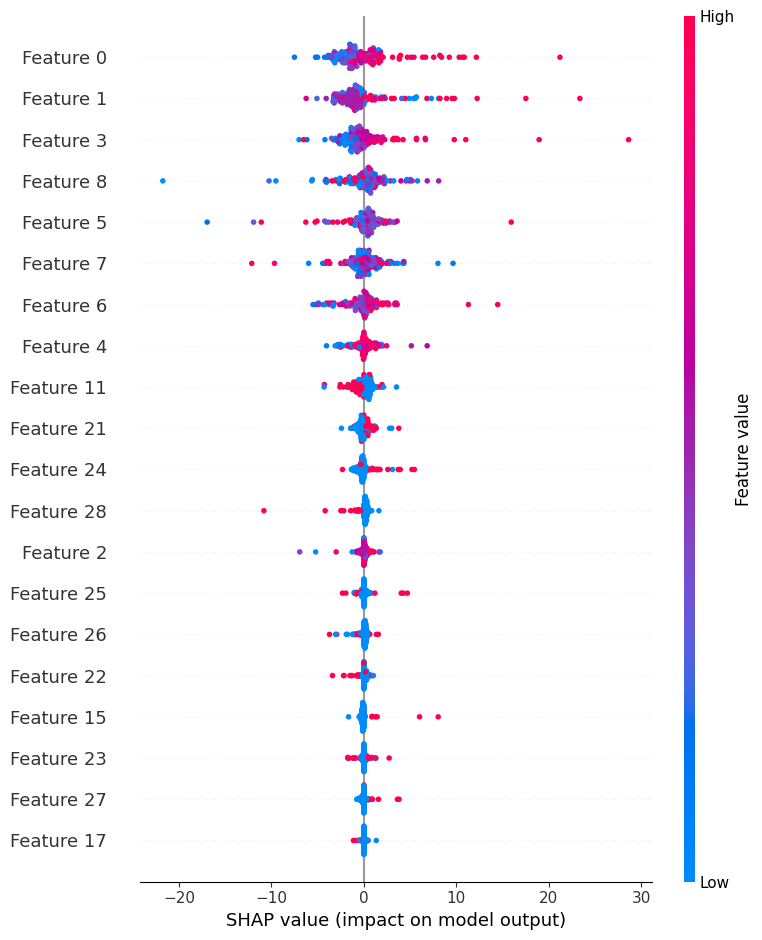

In [142]:
shap.summary_plot(shap_values, data_transform)

##### Answer:

According to the above plot, features with higher SHAP vales are more important. Feature 0 is the most important feature while Feature 17 is the least important feature.

If I'm going to remove features from the model, I would remove Feature 17 because this feature is the least important feature (SHAP value is close to 0). 

After removing Feature 17, we can retrain the model, and check if the SHAP values for the remaining features have changed significantly.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.